In [2]:
# common imports
import numpy as np
import pandas as pd

## Face Detection with Convolutional Neural Networks<a name="cnn"></a>

We will be using the [`MTCNN`](https://pypi.org/project/mtcnn/) implementation available in the Python package to detect faces in a sample photo.

Note: you may need to run `pip install MTCNN` in order for the following cells to run.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
%matplotlib inline

2024-09-22 09:39:12.431061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


After loading the image and creating an object of the MTCNN class, use the `detect_faces` function on the image to detect the faces in the image.

1/1 [==============================] - 0s 189ms/step


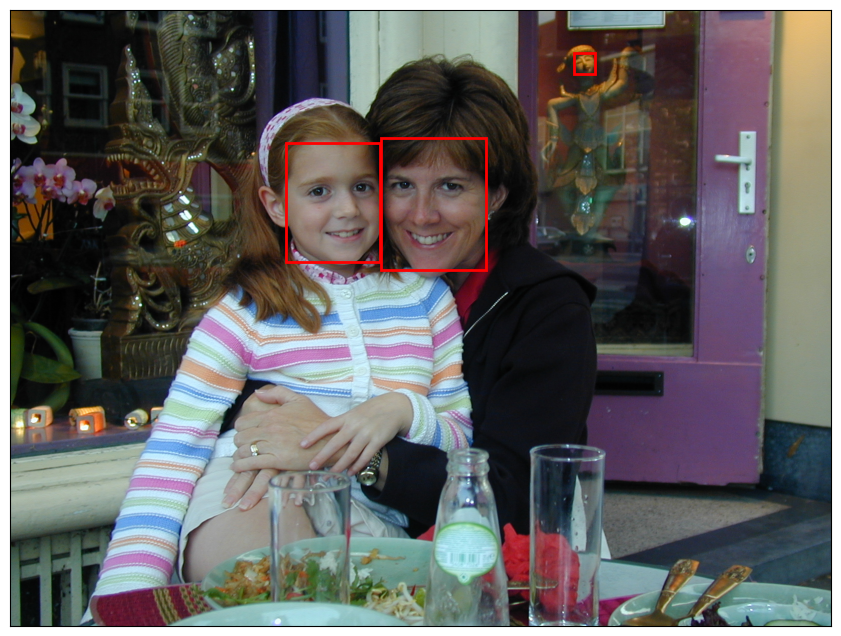

In [3]:
# Load the image
image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

# Detect the faces in the image
detector = MTCNN()
faces = detector.detect_faces(image)


# Use a rectangle to outline the faces in the image
for face in faces:
    x, y, w, h = face['box']
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

Take a look at the output. How many faces did the MTCNN model detect? The `detect_faces` function returned a list containing three dictionaries, each corresponding to one of the faces in the photo.

In [5]:
faces
# confidnence = how sure it is that a bounding box is a face.

[{'box': [723, 248, 204, 258],
  'confidence': 0.9997799396514893,
  'keypoints': {'left_eye': (765, 341),
   'right_eye': (858, 343),
   'nose': (800, 408),
   'mouth_left': (770, 432),
   'mouth_right': (864, 433)}},
 {'box': [538, 258, 183, 232],
  'confidence': 0.9997591972351074,
  'keypoints': {'left_eye': (601, 353),
   'right_eye': (685, 344),
   'nose': (662, 394),
   'mouth_left': (614, 433),
   'mouth_right': (689, 424)}},
 {'box': [1099, 84, 40, 41],
  'confidence': 0.8863284587860107,
  'keypoints': {'left_eye': (1108, 101),
   'right_eye': (1123, 96),
   'nose': (1116, 102),
   'mouth_left': (1114, 115),
   'mouth_right': (1127, 111)}}]

Take a look at each of the keys in the dictionary. The confidence metric represents the probability for a bounding box to be matching a face. Our model was much more confident that the first 2 bounding boxes matched a face than the third one.

We can eliminate the bounding box that outlines the statue by ignoring faces with a confidence threshold below a certain level.

1/1 [==============================] - 0s 166ms/step


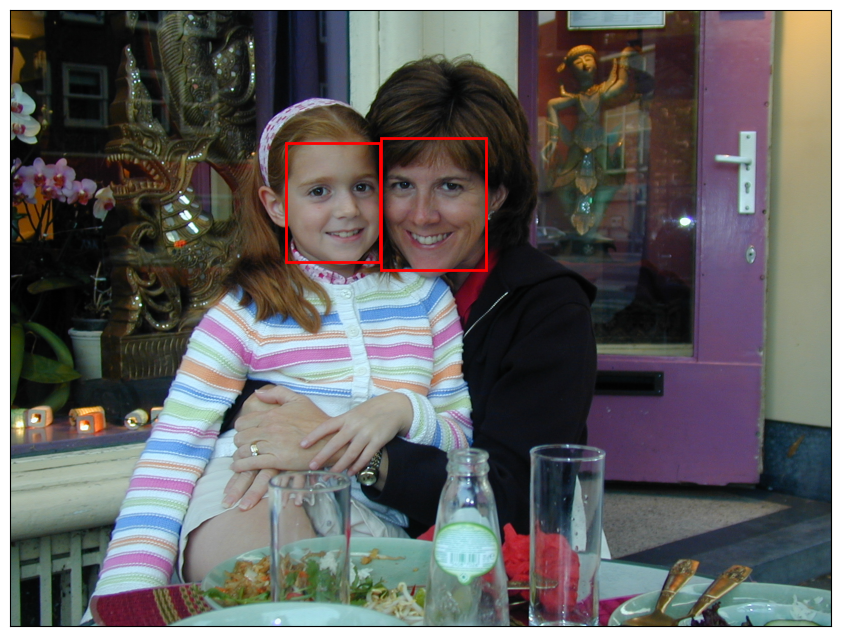

In [7]:
image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

detector = MTCNN()
faces = detector.detect_faces(image)

for face in faces:
    if face['confidence']>0.9: # only add rectangles to the girl and mom
        x, y, w, h = face['box']
        rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
        ax.add_patch(rect)

Another way to eliminate the statue face would be to pass a `min_face_size` parameter to the `MTCNN` function so that `detect_faces` ignores faces smaller than a specified size.

## Applying Transfer Learning to Facial Recognition<a name="recognition"></a>

We can use Covolutional Neural Networks and transfer learning on the Labeled Faces in the Wild dataset that we used in previous examples to perform facial recognition.

Load the LFW dataset.

In [8]:
faces_data = np.loadtxt('data/lfw_data.txt')
faces_target = np.loadtxt('data/lfw_target.txt').astype('int')
faces_target_names = np.loadtxt('data/lfw_target_names.txt', delimiter=",", dtype=str)
faces_images = faces_data.reshape(1140, 128, 128, 3)

print(faces_target_names)
print(faces_images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


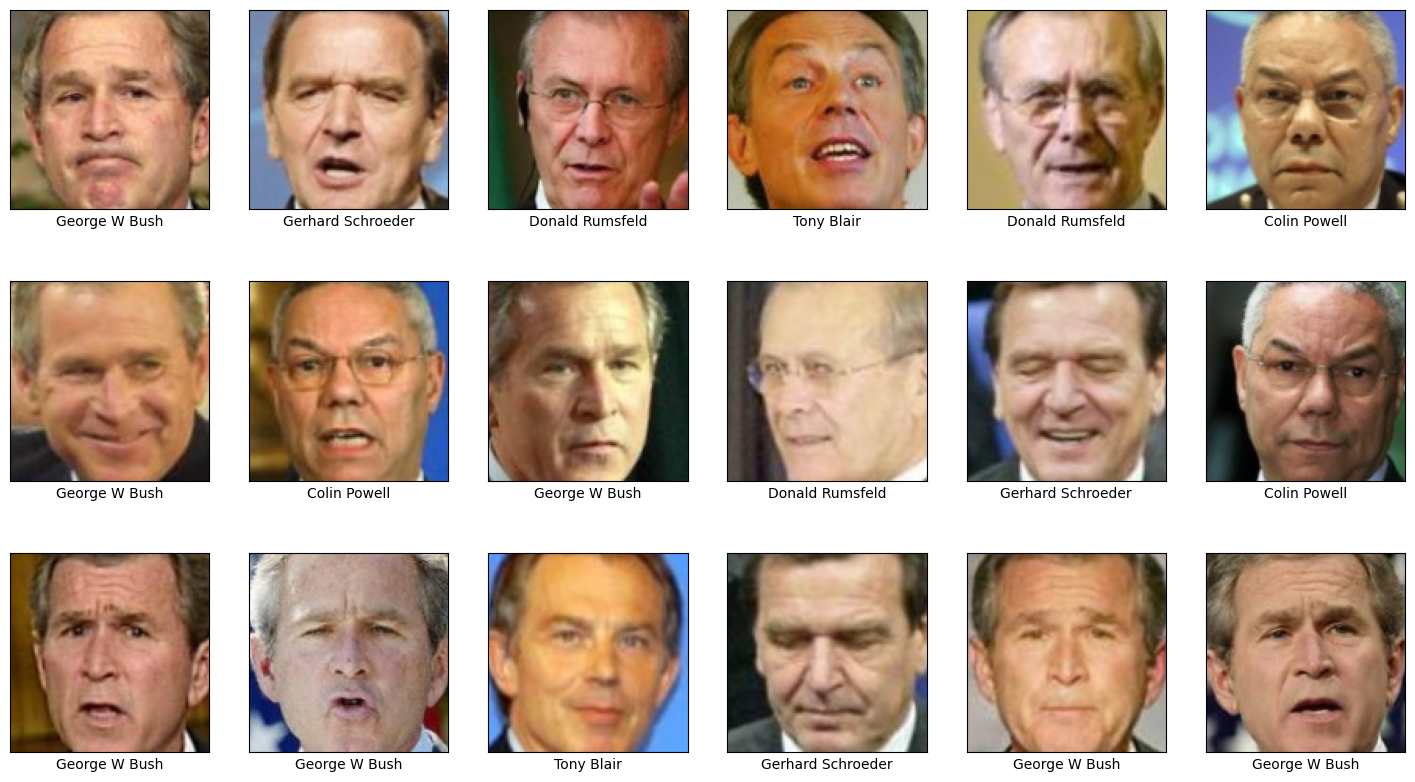

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(3, 6, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces_images[i] / 255)
    axi.set(xticks=[], yticks=[], xlabel=faces_target_names[faces_target[i]])

Recall the imbalance in our dataset. There are a lot more images of George W Bush than the others. We will reduce the dataset to 100 images of each person to create a balanced dataset.

In [10]:
mask = np.zeros(faces_target.shape, dtype=bool)

for target in np.unique(faces_target):
    mask[np.where(faces_target == target)[0][:100]] = 1
    
x_faces = faces_data[mask]
y_faces = faces_target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces_images.shape[1], faces_images.shape[2], faces_images.shape[3]))

x_faces.shape

(500, 128, 128, 3)

Now, preprocess the pixel values for input to a pretrained ResNet50 CNN and use Scikit-Learn's `train_test_split` function to split the dataset, yielding 400 training samples and 100 test samples:

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

face_images = preprocess_input(np.array(x_faces))

x_train, x_test, y_train, y_test = train_test_split(face_images, y_faces, train_size=0.8, stratify=y_faces, random_state=0)

Load ResNet50's feature extraction layers, intialize them with the ImageNet weights, and freeze them so that the weights aren't adjusted during training.

In [12]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

94765736/94765736 [==============================] - 2s 0us/step


Add classification layers to the base model and include a `Resizing` layer to resize the images input to the network to the size that ResNet50 expects.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224,224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model and plot the training and validation accuracy.

In [14]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
40/40 [==============================] - 140s 3s/step - loss: 24.7577 - accuracy: 0.6075 - val_loss: 7.2971 - val_accuracy: 0.7400
Epoch 2/10
40/40 [==============================] - 127s 3s/step - loss: 1.6775 - accuracy: 0.9300 - val_loss: 3.4461 - val_accuracy: 0.8800
Epoch 3/10
40/40 [==============================] - 123s 3s/step - loss: 0.5905 - accuracy: 0.9750 - val_loss: 3.4453 - val_accuracy: 0.8800
Epoch 4/10
40/40 [==============================] - 121s 3s/step - loss: 0.0847 - accuracy: 0.9925 - val_loss: 2.9212 - val_accuracy: 0.9000
Epoch 5/10
40/40 [==============================] - 116s 3s/step - loss: 0.1387 - accuracy: 0.9900 - val_loss: 4.1754 - val_accuracy: 0.9000
Epoch 6/10
40/40 [==============================] - 13188s 338s/step - loss: 0.1004 - accuracy: 0.9950 - val_loss: 3.5356 - val_accuracy: 0.8900
Epoch 7/10
40/40 [==============================] - 97s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8224 - val_accuracy: 0.8900
Epoch

[]

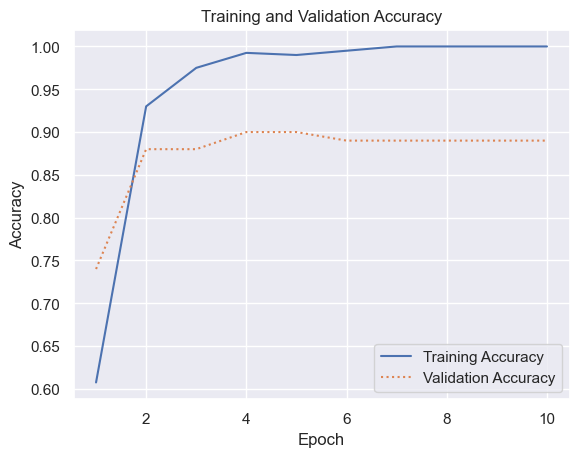

In [15]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

As we can see, the ResNet50 model does well with feature extraction when initialized with the ImageNet weights. The ImageNet weights were determined when ResNet50 was trained on more than a million photos of objects ranging from butterflies to basketballs, but not any facial images. In the next section, we will use a variation of ResNet50 that was trained to recognize celebrity faces.

## Boosting Transfer Learning with Task-Specific Weights<a name="vgg"></a>

In 2017, a group of researchers at the University of Oxford's Visual Geometry Group published a [paper](https://arxiv.org/abs/1710.08092) in which they trained two variations of ResNet50 with several million facial images. The model that is compatible with Tensorflow, which is commonly refered to as `VGGFace`, and the weights arrived at during training are included in the in the Python library `Keras-vggface`.

The bottleneck layers of the trained VGGFace model have been downloaded and are included in the data subdirectory. Load the base model and build the classification layers.

In [16]:
from tensorflow.keras.models import load_model

base_model = load_model('Data/vggface.h5')
base_model.trainable = False

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model with the same LFW data used in the previous section and plot the training and validation accuracy.

Epoch 1/10
40/40 [==============================] - 60s 1s/step - loss: 0.3364 - accuracy: 0.9550 - val_loss: 3.5499e-05 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 57s 1s/step - loss: 8.9407e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 58s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 58s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
40/40 [==============================] - 57s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 57s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
40/40 [==============================] - 56s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

[]

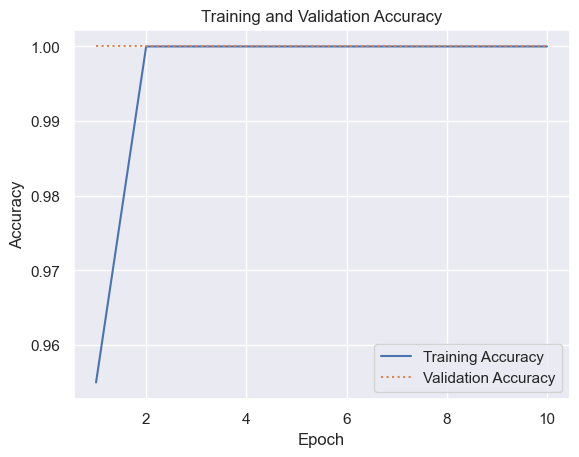

In [17]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

The accuracy of the VGFace model is incredibly impressive. Run the test data through the network and take a look at the confusion matrix.

4/4 [==============================] - 11s 2s/step


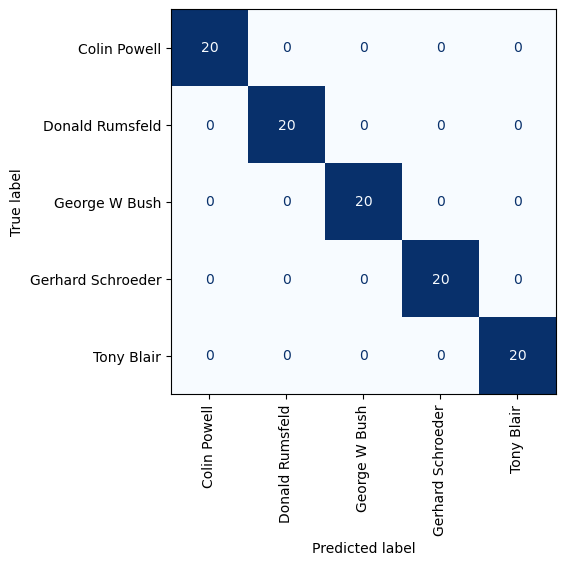

In [18]:
# run the test data through the model
y_pred = model.predict(x_test)

# plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
sns.reset_orig()
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)
cmd.from_predictions(y_test, y_pred.argmax(axis=1), display_labels=faces_target_names, colorbar=False, cmap='Blues', xticks_rotation='vertical', ax=ax)

Again, incredibly impressive. 

As seen in this example, CNNs that are trained in task-specific ways frequently provide a better base for transfer learning than CNNs trained in a more generic fashion.

## Putting It All Together: Detecting and Recognizing Faces in Photos<a name="together"></a>

In this exercise, we will train a facial recognition model that uses an MTCNN to detect faces in photos and uses VGGFace to identify the faces that the MTCNN detects. We'll use a dataset containing eight pictures each of three ordinary people in slightly different poses, at ages up to 20 years apart, with and without glasses. These images are seen below and can be found in the directory `data/faces`.

<img src="data/face_images.jpeg" width="700" height="400">

The below code defines helper functions for loading and displaying the facial images, and declares a pair of lists to hold the images and labels.

In [19]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []
    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

First, load the images of Jeff and label them with 0s.

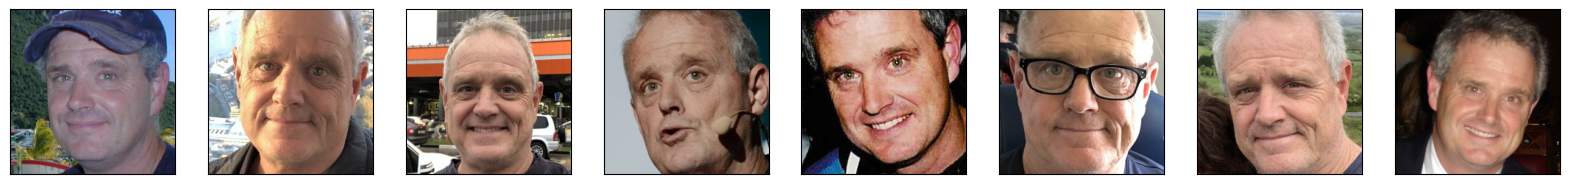

In [22]:
images, labels = load_images_from_path('data/faces/Jeff',0)
show_images(images)

x += images
y += labels

Next, load the images of Lori and label them with 1s.

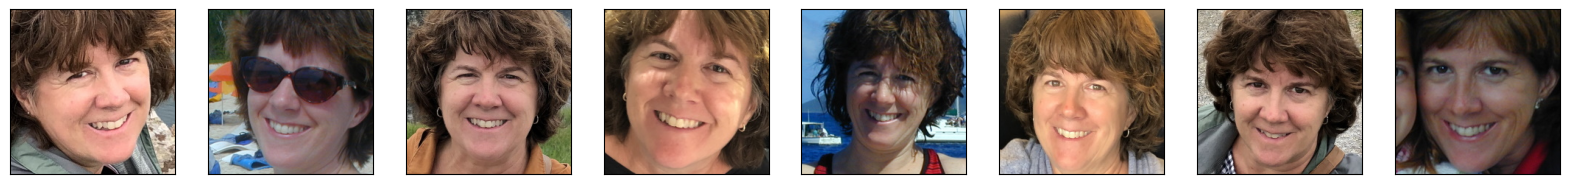

In [24]:
images, labels = load_images_from_path('data/faces/Lori',1)
show_images(images)

x += images
y += labels

Then, load the images of Abby and label them with 2s.

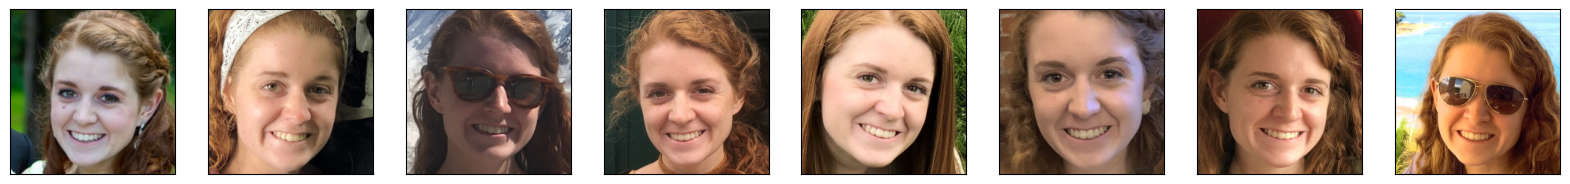

In [25]:
images, labels = load_images_from_path('data/faces/Abby',2)
show_images(images)

x += images
y += labels

Preprocess the pixels for the ResNet50 version of VGGFace and split the data 50/50 so that the network will be trained with four randomly selected images of each person and validated with the same number of images.

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

faces = preprocess_input(np.array(x))
labels = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(faces, labels, train_size=0.5, stratify=labels, random_state=0)

The next step is to load the saved VGGFace model and freeze the bottleneck layers.

In [27]:
base_model = load_model('Data/vggface.h5')
base_model.trainable = False

Define a network that uses transfer learning with VGGFace to identify faces. We'll add a `Resizing` layer to ensure that each image measures 244 $\times$ 244 pixels.

In [29]:
model = Sequential()
model.add(Resizing(224,224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Now, train the model.

In [30]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=2, epochs=10)

Epoch 1/10
6/6 [==============================] - 8s 694ms/step - loss: 1.0234 - accuracy: 0.5833 - val_loss: 0.0586 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 3s 468ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 3s 552ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 3s 601ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 3s 575ms/step - loss: 8.3600e-04 - accuracy: 1.0000 - val_loss: 7.8556e-04 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 3s 522ms/step - loss: 5.7707e-04 - accuracy: 1.0000 - val_loss: 6.3372e-04 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 3s 499ms/step - loss: 4.1754e-04 - accuracy: 1.0000 - val_loss: 5.5732e-04 - val_accuracy: 1.0

The following code defines two helper functions:
- `get_face()` retrieves a face from a specified location in an image
- `label_faces()` loads a photo and annotates faces in the photo with names and confidence levels

In [31]:
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from matplotlib.patches import Rectangle

def get_face(image, face):
    x1, y1, w, h = face['box']
    
    if w > h:
        x1 = x1 + ((w - h) // 2)
        w = h
    elif h > w:
        y1 = y1 + ((h - w) // 2)
        h = w
        
    x2 = x1 + h
    y2 = y1 + w
    
    return image[y1:y2, x1:x2]

def label_faces(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    fig, ax = plt.subplots(figsize=size, subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(np_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
        # Optionally draw a box around the face
            if show_outline:
                rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
                ax.add_patch(rect)

            # Label the face
            index = int(np.argmax(predictions))
            text = f'{names[index]} ({confidence:.1%})'
            ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red', ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))

Pass a few sample images in the `Samples` directory to `label_faces`.

1/1 [==============================] - 1s 1s/step


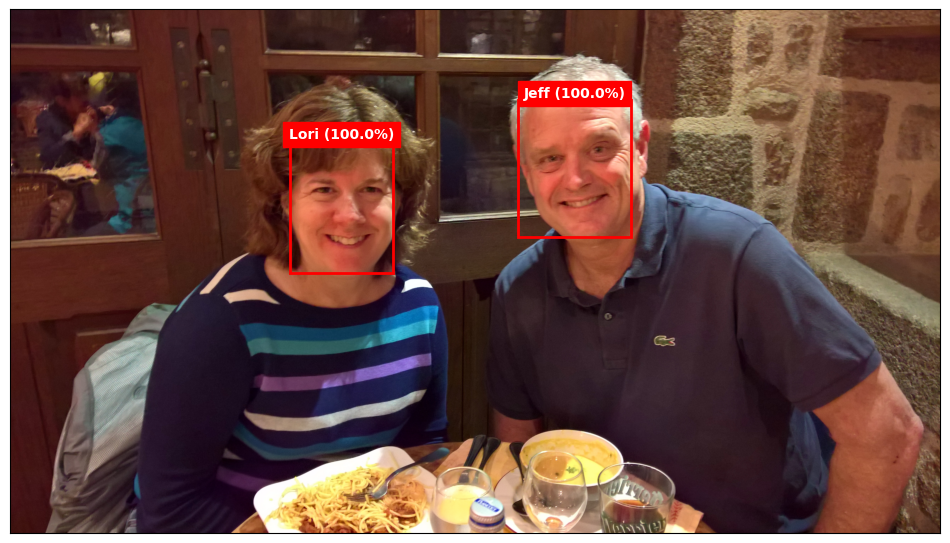

In [32]:
labels = ['Jeff', 'Lori', 'Abby']
label_faces('data/faces/Samples/Sample-1.jpg', model, labels)

1/1 [==============================] - 0s 163ms/step


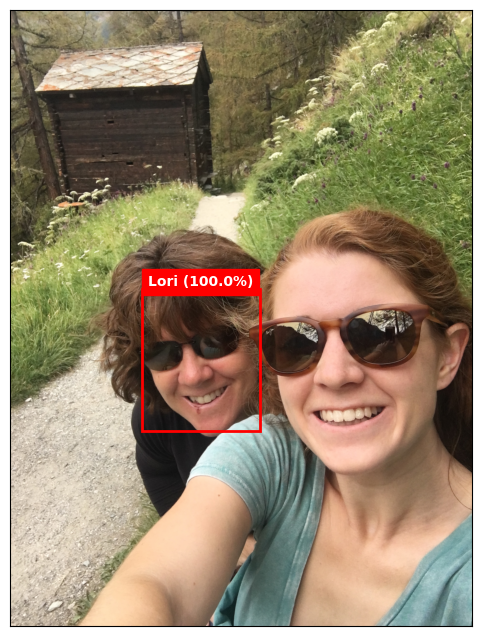

In [35]:
label_faces('data/faces/Samples/Sample-2.jpg', model, labels)

1/1 [==============================] - 0s 176ms/step


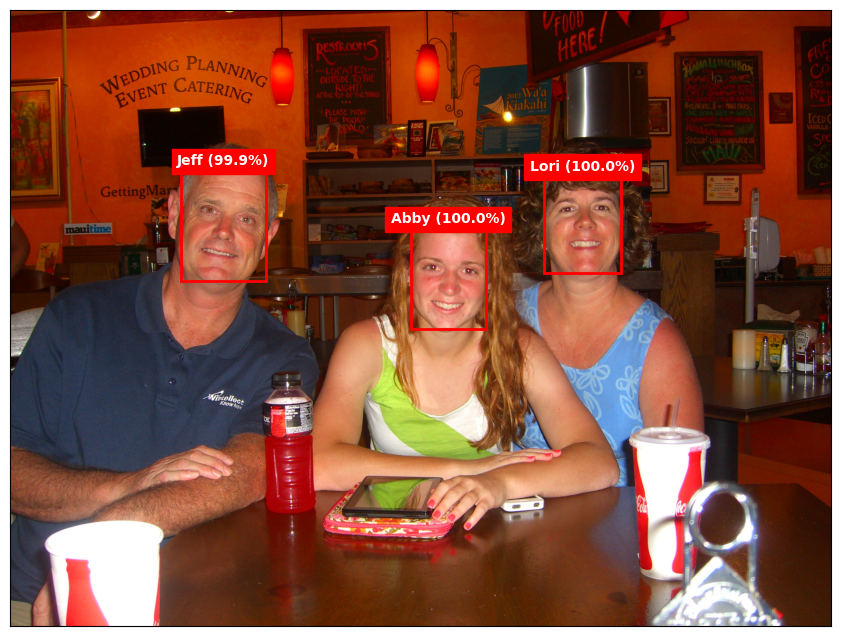

In [34]:
label_faces('data/faces/Samples/Sample-3.jpg', model, labels)

Even with such a small training set, the model does well identifying faces in photos. You could train the same model with photos of your friends and family and see how well it does in identifying them.